In [58]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2
from scipy.linalg import sqrtm
from numpy.linalg import det
import numpy.linalg as LA
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import numpy as np
from scipy.stats import invwishart as iw        
import matplotlib.pyplot as plt

def plot_ellipse(covariance, ax, label_t="", linestyle='', alpha_val=0.25, color_def='red', center = [0, 0]):
    if covariance.shape[0] == 2:
        x_el = np.array([np.sin(np.linspace(0, 2*math.pi, num=63)), np.cos(np.linspace(0, 2*math.pi, num=63))])
        C = np.linalg.cholesky(covariance)
        y_el = np.dot(C, x_el)
        if len(linestyle) > 0:
            if len(label_t) > 0:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], label=label_t, alpha=alpha_val, color=color_def, linestyle=linestyle)
            else:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], alpha=alpha_val, color=color_def, linestyle=linestyle)            
        else:
            if len(label_t) > 0:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], label=label_t, alpha=alpha_val, color=color_def)
            else:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], alpha=alpha_val, color=color_def) 
                

In [59]:
def inv(A):
    return LA.inv(A)

def relu(v):
    threshold = 1E-5
    if v < 100 and v > threshold:
        return np.log1p(1 + np.exp(v))* threshold /np.log1p(1+np.exp(threshold))
    else:
        return v



def pinv(A):
    RELU = np.vectorize(relu)
    tmp_eig, tmp_egv = LA.eig(A)
    print(tmp_eig)
    M_inv = tmp_egv @ np.diag(1/RELU(tmp_eig)) @ tmp_egv.T
    M = tmp_egv @ np.diag(RELU(tmp_eig)) @ tmp_egv.T
    return M


def generate_covariance(true_mu, dims, df):
    S = (np.tril(iw.rvs(df, 1, size=dims**2).reshape(dims, dims)))*df
    cov = np.dot(S, S.T)
    while(abs(np.linalg.det(cov)) < 1.5):
        cov = cov + 0.5*np.diag(np.diag(cov))
    mu = np.random.multivariate_normal(true_mu, cov, 1)[0]

    return mu, cov

def mutual_covariance(cov_a, cov_b):
    D_a, S_a = np.linalg.eigh(cov_a)
    D_a_sqrt = sqrtm(np.diag(D_a))
    D_a_sqrt_inv = inv(D_a_sqrt)
    M = np.dot(np.dot(np.dot(np.dot(D_a_sqrt_inv, inv(S_a)), cov_b), S_a), D_a_sqrt_inv)    # eqn. 10 in Sijs et al.
    D_b, S_b = np.linalg.eigh(M)
    D_gamma = np.diag(np.clip(D_b, a_min=1.0, a_max=None))   # eqn. 11b in Sijs et al.
    return np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(S_a, D_a_sqrt), S_b), D_gamma), inv(S_b)), D_a_sqrt), inv(S_a))  # eqn. 11a in Sijs et al

def get(dims, df):
    true_mu = np.zeros((dims, ))

    x_ac, C_ac = generate_covariance(true_mu, dims, df)
    x_c, C_c = generate_covariance(true_mu, dims, df)
    x_bc, C_bc = generate_covariance(true_mu, dims, df)

    C_a = LA.inv(LA.inv(C_ac) + LA.inv(C_c))
    C_b = LA.inv(LA.inv(C_bc) + LA.inv(C_c))

    x_a = C_a @ (LA.inv(C_ac) @ x_ac + LA.inv(C_c) @ x_c)
    x_b = C_b @ (LA.inv(C_bc) @ x_bc + LA.inv(C_c) @ x_c)

    C_fus = LA.inv(LA.inv(C_a) + LA.inv(C_b) - LA.inv(C_c))

    x_fus = C_fus @ (LA.inv(C_ac) @ x_ac + LA.inv(C_bc) @ x_bc + LA.inv(C_c) @ x_c)

    return x_a.reshape(1, dims), x_b.reshape(1, dims), C_a, C_b, C_fus, x_fus

def get_critical_value(dimensions, alpha):
    return chi2.ppf((1 - alpha), df=dimensions)

eta = get_critical_value(2, 0.05)

In [60]:
df = 100
x_a, x_b, C_a, C_b, C_fus, t_x_fus = get(2, df)
x_a = x_a.reshape(1, 2)
x_b = x_b.reshape(1, 2)
S_0 = np.array([0, 0])

In [61]:
def objective(S):
    S = S.reshape(1, 2)
    return np.trace(S.T @ S)

def constraint1(S):
    S = S.reshape(1, 2)    
    A = S.T @ S - 1e-10*np.identity(2)
    return np.linalg.eig(A)[0][0]

def constraint2(S):
    S = S.reshape(1, 2)    
    A = S.T @ S - 1e-10*np.identity(2)
    return np.linalg.eig(A)[0][1]

def prob_constraint(S):
    S = S.reshape(1, 2)    
    C_c_inv = LA.inv(mutual_covariance(C_a, C_b) + 1e-10*np.identity(2) + S.T @ S)

    C_ac = LA.inv(inv(C_a) - C_c_inv)
    C_bc = LA.inv(inv(C_b) - C_c_inv)

    C_abc_inv_inv = LA.inv(LA.inv(C_ac) + LA.inv(C_bc))
    C_abc_inv = LA.inv(C_ac + C_bc)

    x_c = (C_abc_inv_inv @ (LA.inv(C_ac) @ x_a.T + LA.inv(C_bc) @ x_b.T)).T
    
    x_ac = (C_ac @ (inv(C_a) @ x_a.T - C_c_inv @ x_c.T)).T
    x_bc = (C_bc @ (inv(C_b) @ x_b.T - C_c_inv @ x_c.T)).T
    
    f = ((x_ac - x_bc) @ LA.inv(C_ac+C_bc) @ (x_ac - x_bc).T)[0][0]
    return eta - f

def debug(S):
    print ('objective is',objective(S))
    print ('constraint1 is ',constraint1(S))
    print ('constraint2 is ',constraint2(S))
    print ('prob_constraint is ',prob_constraint(S))

In [62]:
con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'ineq', 'fun': constraint2}
con3 = {'type': 'eq', 'fun': prob_constraint}
cons = [con1, con2, con3]

In [63]:
sol = minimize(objective, S_0, method='trust-constr', constraints=cons)
print(sol)

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 165
      cg_stop_cond: 2
            constr: [array([-1.00000008e-10]), array([0.09587081]), array([-1.07628573e-09])]
       constr_nfev: [486, 486, 486]
       constr_nhev: [0, 0, 0]
       constr_njev: [0, 0, 0]
    constr_penalty: 1.0
  constr_violation: 1.0762857272084148e-09
    execution_time: 0.5384721755981445
               fun: 0.09587080563408266
              grad: array([0.33324494, 0.52194929])
               jac: [array([[0.00000000e+00, 9.31322575e-10]]), array([[0.33324494, 0.52194929]]), array([[22.8678813 , 35.81712902]])]
   lagrangian_grad: array([ 1.62473783e-08, -1.03733361e-08])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 486
              nhev: 0
               nit: 177
             niter: 177
              njev: 162
        optimality: 1.624737833161305e-08
            status:

In [64]:
debug(sol.x)
C_c_EI =  mutual_covariance(C_a, C_b) + 1e-10*np.identity(2)
S = sol.x
C_c_PC_05 = C_c_EI + S.T @ S

eta = get_critical_value(2, 0.01)
sol = minimize(objective, S_0, method='trust-constr', constraints=cons)
S = sol.x
C_c_PC_01 = C_c_EI + S.T @ S

objective is 0.09587080563408266
constraint1 is  -1.000000082740371e-10
constraint2 is  0.09587080553408267
prob_constraint is  -1.0762857272084148e-09


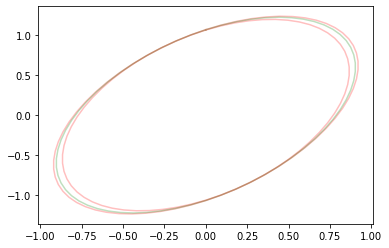

In [65]:
ax = plt.axes()
plot_ellipse(C_c_EI, ax)
plot_ellipse(C_c_PC_05, ax)
plot_ellipse(C_c_PC_01, ax, color_def="green")

In [66]:
fus_PC_05 = inv(inv(C_a) + inv(C_b) - inv(C_c_PC_05))
fus_PC_01 = inv(inv(C_a) + inv(C_b) - inv(C_c_PC_01))
fus_EI = inv(inv(C_a) + inv(C_b) - inv(C_c_EI))

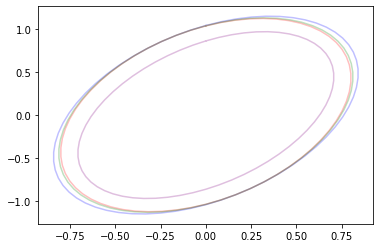

In [67]:
plt.cla()
plt.clf()
ax = plt.axes()
plot_ellipse(fus_EI, ax, color_def="blue")
plot_ellipse(fus_PC_05, ax)
plot_ellipse(fus_PC_01, ax, color_def="green")
plot_ellipse(C_fus, ax, color_def="purple")

In [68]:
print(get_critical_value(2, 0.05))
print(get_critical_value(2, 0.01))

5.991464547107979
9.21034037197618


[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

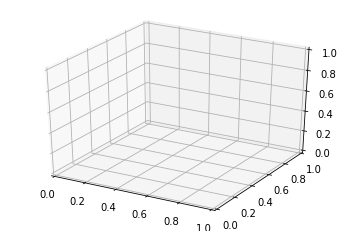

In [75]:
import matplotlib.pyplot as plt

def f(x, y):
    z = np.array([x, y])
    return prob_constraint(z)

fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
print(X[0])
print(X[1])